In [122]:
# First some imports that we'll use below
from __future__ import print_function
import treecorr
import fitsio
import numpy
import math
import time
import pprint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy import stats
#import plotly.plotly as py
#import plotly.graph_objs as go
from astropy.table import Table
from scipy.stats import chisquare
from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance
from astropy.cosmology import WMAP5 as cosmo
from astropy import cosmology

In [2]:
galaxy_sample = 'example/example_data.fit' 
galaxy_catalog = treecorr.Catalog(galaxy_sample, ra_col='RA', dec_col='DEC', ra_units='deg', dec_units='deg')
data = Table.read(galaxy_sample)
 #400k objects
z= numpy.array(data['REDSHIFT'])
ra = numpy.array (data['RA'])
dec = numpy.array(data['DEC'])
#mask = (((ra>1) & (dec>1)) ^ (ra>1) ^ (dec>1))
mask = ((((ra>3) ^ (ra<2)) & ((dec>3)^ (dec<2))) ^ (((ra>3) ^ (ra<2)) ^ ((dec>3)^ (dec<2))))
#mask = ((ra<3) & (dec<3) & (ra>2) & (dec>2))
#mask = ((z<z_max[14]) & (z>z_min[14]))
#print (len(data[mask]))
#for i in range (0,3):
    #for j in range (0,3):
        #mask = ((z<z_max[14]) & (z>z_min[14]))    
        #new_mask = (((((ra>i+1) ^ (ra<i)) & ((dec>j+1)^ (dec<j))) ^ (((ra>i+1) ^ (ra<i)) ^ ((dec>j+1)^ (dec<j)))))
        #print((len(data[new_mask])))


In [3]:
ra_min = numpy.min(galaxy_catalog.ra)
ra_max = numpy.max(galaxy_catalog.ra)
dec_min = numpy.min(galaxy_catalog.dec)
dec_max = numpy.max(galaxy_catalog.dec)
rand_ra = numpy.random.uniform(ra_min, ra_max, len(data)*10) 
rand_sindec = numpy.random.uniform(numpy.sin(dec_min), numpy.sin(dec_max), len(data)*10)  
rand_dec = numpy.arcsin(rand_sindec) #convert back to dec
rand_catalog = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians') 

In [4]:
zed = 0
z_min = []
z_max = []
while (zed < numpy.max(z)):
    z_min.append(zed)
    nzed = zed + 0.001
    mask = ((z>(zed)) & (z<(nzed)))
    check_mask = ((z>(zed)) & (z<(numpy.max(z))))
    if (len(data[check_mask]) < (len(data)/25)):
        z_max.append(numpy.max(z))
        zed=numpy.max(z)
    else:
        while(len(data[mask]) < ((len(data)/25))):
            nzed += 0.001
            mask = (z>(zed)) & (z<(nzed))
        z_max.append(nzed)
        zed = nzed

In [5]:
def jack(i,j,boxID,mask):
    new_xi = []
    new_mask = ((mask) & ((((ra>i+1) ^ (ra<i)) & ((dec>j+1)^ (dec<j))) ^ (((ra>i+1) ^ (ra<i)) ^ ((dec>j+1)^ (dec<j)))))
    nameID = boxID + str(3*j) + str(i) + 'jack'
    jack_name = 'treecorr/' + nameID + '.fits'
    data[new_mask].write(jack_name)
    galaxy_catalog = treecorr.Catalog(jack_name, ra_col='RA', dec_col='DEC', ra_units='deg', dec_units='deg')
    ra_min = numpy.min(galaxy_catalog.ra)
    ra_max = numpy.max(galaxy_catalog.ra)
    dec_min = numpy.min(galaxy_catalog.dec)
    dec_max = numpy.max(galaxy_catalog.dec)
    rand_ra = numpy.random.uniform(ra_min, ra_max, len(data[new_mask])*10) 
    rand_sindec = numpy.random.uniform(numpy.sin(dec_min), numpy.sin(dec_max), len(data[new_mask])*10)  
    rand_dec = numpy.arcsin(rand_sindec) #convert back to dec
    rand_ra_pi = rand_ra*180 / numpy.pi
    rand_cosdec = (rand_dec)*180 / numpy.pi
    ran_mask = (((((rand_ra_pi>i+1) ^ (rand_ra_pi<i)) & ((rand_cosdec>j+1)^ (rand_cosdec<j))) ^ (((rand_ra_pi>i+1) ^ (rand_ra_pi<i)) ^ ((rand_cosdec>j+1)^ (rand_cosdec<j)))))
    #ran_mask = ((rand_ra_pi <1) & (rand_cosdec <1))
    rand_ra = rand_ra[ran_mask]
    rand_dec = rand_dec[ran_mask]
    rand_catalog = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians')
    size = str(len(data[new_mask]))
    size_int = len(data[new_mask])  
    dd = treecorr.NNCorrelation(min_sep=0.005, max_sep=0.1, bin_size=0.06, sep_units='degrees')
    rr = treecorr.NNCorrelation(min_sep=0.005, max_sep=0.1, bin_size=0.06, sep_units='degrees')
    dr = treecorr.NNCorrelation(min_sep=0.005, max_sep=0.1, bin_size=0.06, sep_units='degrees') 
    dd.process(galaxy_catalog)
    rr.process(rand_catalog)
    dr.process(galaxy_catalog,rand_catalog) 
    xi, varxi = dd.calculateXi(rr,dr)
    return (xi)

In [6]:
A_value = []
g_value = []
A_err = []
g_err = []
r_value = []
xi_value = []
yfit_eq = []
sig_value = []
N_size = []
chisqr = []
yfit_max = []
yfit_min = []
xi_err = []
DD_val = []
RR_val= []
N_sizeint =[]
new_xi = []
jack_xi = []
final_jack = []
newxi = [] 
A_logerr = []

In [7]:
def tree2():
   for zd in range (0,25):
       boxID = str(zd+1)
       mask = (z>(z_min[zd])) & (z<(z_max[zd]))
       file_name = 'treecorr/' + boxID + '.fits' 
       print (file_name) 
       data[mask].write(file_name)
       galaxy_catalog = treecorr.Catalog(file_name, ra_col='RA', dec_col='DEC', ra_units='deg', dec_units='deg') 
       #ra_min = numpy.min(galaxy_catalog.ra)
       #ra_max = numpy.max(galaxy_catalog.ra)
       #dec_min = numpy.min(galaxy_catalog.dec)
       #dec_max = numpy.max(galaxy_catalog.dec)
       rand_ra = numpy.random.uniform(ra_min, ra_max, len(data[mask])*10) 
       rand_sindec = numpy.random.uniform(numpy.sin(dec_min), numpy.sin(dec_max), len(data[mask])*10)  
       rand_dec = numpy.arcsin(rand_sindec) #convert back to dec
       rand_catalog = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians') 
       size = str(len(data[mask]))
       size_int = len(data[mask])  
       dd = treecorr.NNCorrelation(min_sep=0.005, max_sep=0.1, bin_size=0.06, sep_units='degrees')
       rr = treecorr.NNCorrelation(min_sep=0.005, max_sep=0.1, bin_size=0.06, sep_units='degrees')
       dr = treecorr.NNCorrelation(min_sep=0.005, max_sep=0.1, bin_size=0.06, sep_units='degrees') 
       dd.process(galaxy_catalog)
       rr.process(rand_catalog)
       dr.process(galaxy_catalog,rand_catalog) 
       xi, varxi = dd.calculateXi(rr,dr) 
       fits_name = 'treecorr' + boxID + '.fits' 
       dd.write (fits_name,rr, dr)
       dd_read = Table.read(fits_name)
       DD = dd_read['DD']
       RR = dd_read['RR'] 
       r = numpy.exp(dd.meanlogr)
       sig = numpy.sqrt(varxi)
       logr = numpy.log(numpy.absolute(r))
       logxi = numpy.log(numpy.absolute(xi))
       m, c = numpy.polyfit(logr, logxi, 1)
       y_fit = numpy.exp(m*logr + c)
       gamma = 1-m
       A = numpy.exp(c)
       r_value.append(r)
       xi_value.append(xi)
       sig_value.append(sig)
       N_size.append(size)
       N_sizeint.append(size_int)
       DD_val.append(DD)
       RR_val.append(RR) 
       p, V = numpy.polyfit(logr, logxi, 1, cov=True) 
       m_error = numpy.sqrt(V[0][0])
       c_error = numpy.sqrt(V[1][1])
       gamma_error = gamma - (1-(m-m_error))
       A_error = A - numpy.exp(c-c_error)
       y_fitmax = numpy.exp((m+m_error)*logr + (c+ c_error))
       y_fitmin =  numpy.exp((m-m_error)*logr + (c- c_error))
       yfit_eq.append(y_fit)
       yfit_max.append (y_fitmax)
       yfit_min.append (y_fitmin)
       A_value.append(A)
       g_value.append(gamma)
       A_err.append (A_error)
       A_logerr.append(c_error)
       g_err.append (numpy.abs(gamma_error))
       newxi = [] 
       final_jack= []
       print ( 'A value = %.6f' %(A), '+/- %.6f'  %(A_error), 'Gamma value = %.6f..'%(gamma), '+/- %.6f'  %(gamma_error))
       for i in range (0,3):
            for j in range (0,3):
                newxi.append(numpy.array(jack(i,j, boxID,mask)))
       for n in range (0,50) :
           jack_xi=[]
           for count in range (0,9): 
               jack_xi.append(newxi[count][n])    
           final_jack.append(jack_xi)
       new_xi.append(final_jack)

In [8]:
tree2()

treecorr/1.fits
A value = 0.002816 +/- 0.001178 Gamma value = 1.695969.. +/- -0.139149
treecorr/2.fits
A value = 0.016701 +/- 0.002149 Gamma value = 1.607152.. +/- -0.035362
treecorr/3.fits
A value = 0.075851 +/- 0.005437 Gamma value = 1.505077.. +/- -0.019094
treecorr/4.fits
A value = 0.018722 +/- 0.002245 Gamma value = 1.691342.. +/- -0.032800
treecorr/5.fits
A value = 0.030734 +/- 0.003307 Gamma value = 1.659623.. +/- -0.029227
treecorr/6.fits
A value = 0.043049 +/- 0.005087 Gamma value = 1.721284.. +/- -0.032280
treecorr/7.fits
A value = 0.071591 +/- 0.003536 Gamma value = 1.564363.. +/- -0.013004
treecorr/8.fits
A value = 0.033681 +/- 0.003107 Gamma value = 1.705991.. +/- -0.024846
treecorr/9.fits
A value = 0.036511 +/- 0.003817 Gamma value = 1.796979.. +/- -0.028348
treecorr/10.fits
A value = 0.031735 +/- 0.001896 Gamma value = 1.693344.. +/- -0.015814
treecorr/11.fits
A value = 0.024563 +/- 0.001484 Gamma value = 1.688549.. +/- -0.015994
treecorr/12.fits
A value = 0.082224 +/- 0

In [9]:
def_xi = []
def_err = []
for point in range (0, len(new_xi)):
    final_xi = []
    final_err = []
    for nu in range (0, len(new_xi[point])):
        test_statistic = numpy.mean
        jack_point = numpy.array(new_xi[point][nu])
        estimate, bias, stderr, conf_interval = jackknife_stats(jack_point, test_statistic, 0.95)
        final_xi.append (estimate)
        final_err.append (stderr)
    def_xi.append(final_xi)
    def_err.append(stderr)

In [15]:
cov_final = []
cov_diag = []
for red in range (0,25):
    cov_mat = []
    cov_var = []
    for cell in range (0,50):    
        sum_cov = 0
        for num in range (0,9):
            sub = xi_value[red][cell] - new_xi[red][cell][num]
            cov = math.pow(sub, 2)
            sum_cov+=cov
        cot = math.sqrt(sum_cov*8/9)
        cot_var = sum_cov*8/9
        cov_var.append(cot_var)
        cov_mat.append((cot))
    cov_final.append(cov_mat)
    cov_diag.append(cov_var)

In [16]:
covi_def = []
for dif in range (0,25):
    covi_final = []
    for red in range (0,50):
        covi_mat = []
        count = 0
        for cell in range (0,50):    
            sum_covi = 0
            for num in range (0,9):
                subi = (xi_value[dif][count] - new_xi[dif][count][num])
                subj = (xi_value[dif][red] - new_xi[dif][red][num])
                covi = subi*subj
                sum_covi+=covi
            tot = (sum_covi*8/9)
            #coti = math.sqrt(tot)
            covi_mat.append((tot))
            count =count+1
        covi_final.append(covi_mat)
    covi_def.append(covi_final)

In [42]:
corr_def = []
for cov in range (0,25):
    covinv = numpy.linalg.inv(numpy.diag(cov_final[cov]))
    corr = numpy.dot(covinv ,numpy.dot(covi_def[cov], covinv))
    corr_def.append(corr)

In [18]:
log_error = []
for redshift in range (0,25):
    new_error = []
    for den in range (0,50):
        new_error.append (0.434*cov_final[redshift][den]/xi_value[redshift][den])
    log_error.append(new_error)

In [19]:
fin_A = []
fin_gamma = []
fin_Aerr = []
fin_gerr = []
for shift in range (0,25): 
    new_A = []
    new_gamma = []
    s_sum = 0
    sx_sum = 0
    sy_sum = 0
    sxx_sum = 0
    sxy_sum = 0
    for num in range (0,50):
        err = math.pow(log_error[shift][num],2)
        s = 1/err
        s_sum +=s
        sx = numpy.log(r_value[shift][num])/err
        sx_sum += sx
        sy = numpy.log(numpy.absolute(xi_value[shift][num]))/err
        sy_sum += sy
        sxx = sx = math.pow(numpy.log(r_value[shift][num]),2)/err
        sxx_sum += sxx 
        sxy = numpy.log(numpy.absolute(xi_value [shift][num]))*numpy.log(r_value[shift][num])/err
        sxy_sum += sxy
    delta = s_sum*sxx_sum - math.pow(sx_sum,2)
    a = (sxx_sum*sy_sum - sx_sum*sxy_sum)/delta
    b = (s_sum * sxy_sum - sx_sum*sy_sum)/delta
    err_alog = numpy.sqrt(sxx_sum/delta)
    err_a = err_alog * numpy.exp(a)/0.434
    err_b = numpy.sqrt(s_sum/delta)
    new_A.append(numpy.exp(a))
    new_gamma.append(1-b)
    fin_A.append(new_A)
    fin_gamma.append(new_gamma)
    fin_Aerr.append(err_a)
    fin_gerr.append(err_b)


In [20]:
A_newerr = []
for dn in range (0,25):
    newa = A_logerr[dn]* A_value[dn]/0.434
    A_newerr.append(newa)

In [21]:
fin_fit = []
for l in range (0,25):
    g = sum(fin_gamma[l])
    slope = 1-g
    new_fit = numpy.exp((slope)*numpy.log(r_value[l]) + numpy.log(fin_A[l]))
    fin_fit.append(new_fit)

In [22]:
for red in range (0,25):
    #def_xi = 0
    tell = 0
    fin_xi = 0
    for i in range (0,50):
        #for j in range (0,50):
        xi_resti = (numpy.log(numpy.absolute(xi_value[red][i]))- numpy.log(yfit_eq[red][i]))
        #xi_restj = xi_value[red][j] - yfit_eq[red][j]
        #cov_inv = numpy.linalg.inv(covi_def[red])
        error = log_error[red][i]*log_error[red][i]
        #print (error,xi_resti*xi_resti)
        comb = xi_resti*xi_resti/(error)
        #print(xi_value[red][i], yfit_eq[red][i], cov_final[red][i] )
        tell +=comb
    fin = tell/48
    print (fin)

2.3641211714
0.846883885675
1.6127812483
3.35230131643
3.47711211213
2.20515932537
0.67035378932
3.59639654395
3.0482730923
2.50596980151
1.27448126838
0.246709475391
0.8775371369
2.018334824
0.43852994189
1.1357196381
0.93945907081
0.907951214151
1.3950714051
1.06487857679
1.07367814035
1.22701694483
4.15705573456
1.52000169351
1.13904683793


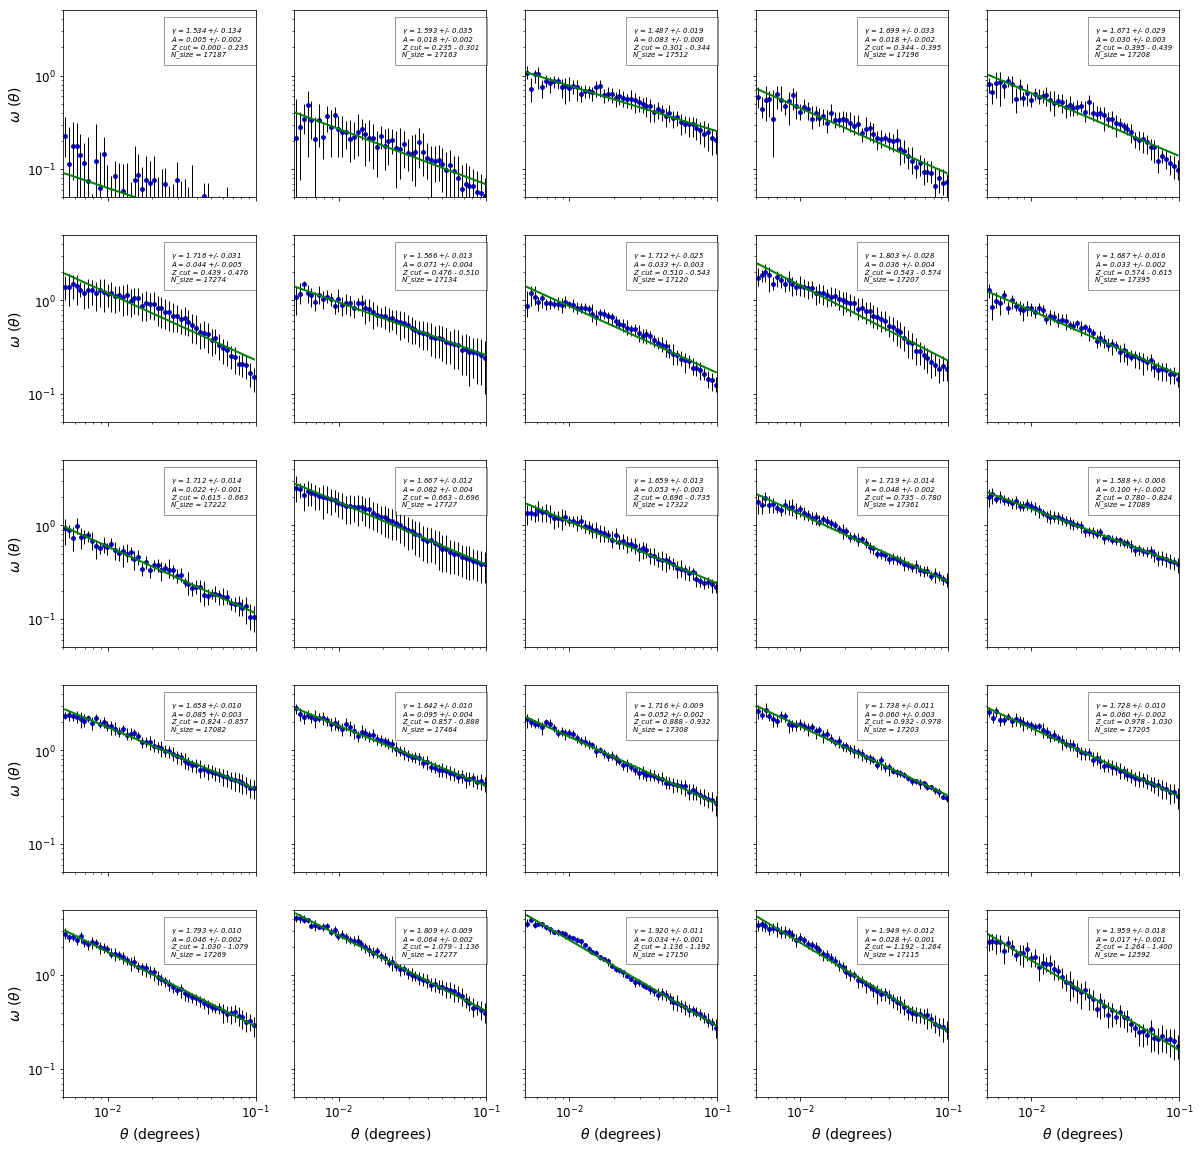

In [79]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (20,20))
rep = []
for i in range(5):
    rep.append (5*i)
    for j in range(5):
        ax[i, j].plot(r_value[rep[i] + j], yfit_eq[rep[i] + j], color = 'green', lw = 2)
        ax[i,j].scatter(r_value[rep[i] + j], xi_value[rep[i] + j], color='blue', s = 15)
        ax[i,j].scatter(r_value[rep[i] + j], -xi_value[rep[i] + j], color='blue', s = 15)
        #ax[i,j].errorbar(r_value[rep[i] + j], xi_value[rep[i] + j], yerr = xi_err[rep[i] + j], color='black', lw=1, ls='')
        #ax[i,j].errorbar(r_value[rep[i] + j], -xi_value[rep[i] + j], yerr= xi_err[rep[i] + j], color='black', lw=1, ls='')                 
        ax[i,j].errorbar(r_value[rep[i] + j], def_xi[rep[i] + j], yerr = cov_final[rep[i] + j], color='black', lw=1, ls='')
        ax[4,j].set_xlabel(r'$\theta$ (degrees)', fontsize= 14)
        ax[i,0].set_ylabel(r'$\omega$ ($\theta$)', fontsize = 14)
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log', nonposy='clip')
        ax[i,j].tick_params (axis = 'both', labelsize = 12)
        ax[i,j].set_xlim(0.005, 0.1)
        ax[i,j].set_ylim(0.05, 5)
        ax[i,j].text (0.027,1.65, r'$\gamma$ = %.3f' % (g_value[rep[i] + j]) + ' +/- %.3f' %(g_err[rep[i] + j])
          + '\n' + r'A = %.3f' % (A_value[rep[i] + j]) + ' +/- %.3f' %(A_err[rep[i] + j])
          + '\n' + r'Z_cut = %.3f' % (z_min[rep[i] + j]) + ' - %.3f' % (z_max[rep[i] + j])
          + '\n' + 'N_size = ' + (N_size[rep[i] + j]),
          #+ '\n' + 'X/ndof = %.3f' %(chisqr[rep[i] + j]) 
          style='italic', fontsize = 7, bbox={'facecolor':'white', 'alpha':0.4, 'pad':7})
fig.savefig('picss.png')

In [116]:
def spec(num):    
    plt.plot(r_value[num-1], yfit_eq[num-1], color = 'green', lw = 2)
    plt.plot(r_value[num-1], fin_fit[num-1], color = 'red', lw = 2)
    plt.scatter(r_value[num-1], xi_value[num-1], color='blue', s = 15)
    #plt.scatter(r_value[0], -xi_value[0], color='blue', s = 15)
    #plt.errorbar(r_value[num-1], xi_value[num-1], yerr = error[num-1], color='black', lw=1, ls='')
    #plt.errorbar(r_value[num-1], -xi_value[num -1], yerr= error[num-1], color='black', lw=1, ls='') 
    plt.errorbar(r_value[num -1], xi_value[num-1], yerr = (cov_final[num-1]), color='black', lw=1, ls='')
    plt.xlabel(r'$\theta$ (degrees)', fontsize= 14)
    plt.ylabel(r'$\omega$ ($\theta$)', fontsize = 14)
    #plt.xscale('linear')
    #plt.yscale('linear')
    plt.xscale('log')
    plt.yscale('log', nonposy='clip')
    plt.tick_params (axis = 'both', labelsize = 12)
    plt.xlim(0.005, 0.1)
    plt.ylim(numpy.min(xi_value[num -1]),numpy.max(xi_value[num -1]))
    #plt.text (0.027,1.65, r'$\gamma$ = %.3f' % (g_value[num-1]) + ' +/- %.3f' %(g_err[num-1])
    #+ '\n' + r'A = %.3f' % (A_value[num-1]) + ' +/- %.3f' %(A_err[num-1])
    #+ '\n' + r'Z_cut = %.3f' % (z_min[num-1]) + ' - %.3f' % (z_max[num-1])
    #+ '\n' + 'N_size = ' + (N_size[num-1]),
    #+ '\n' + 'X/ndof = %.3f' %(chisqr[num -1]) 
    #style='italic', fontsize = 7, bbox={'facecolor':'white', 'alpha':0.4, 'pad':7})

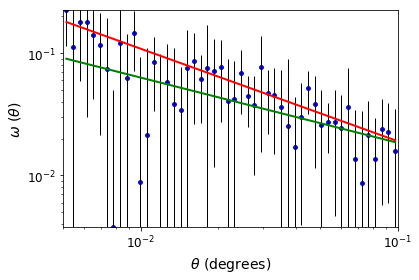

In [117]:
spec(1)

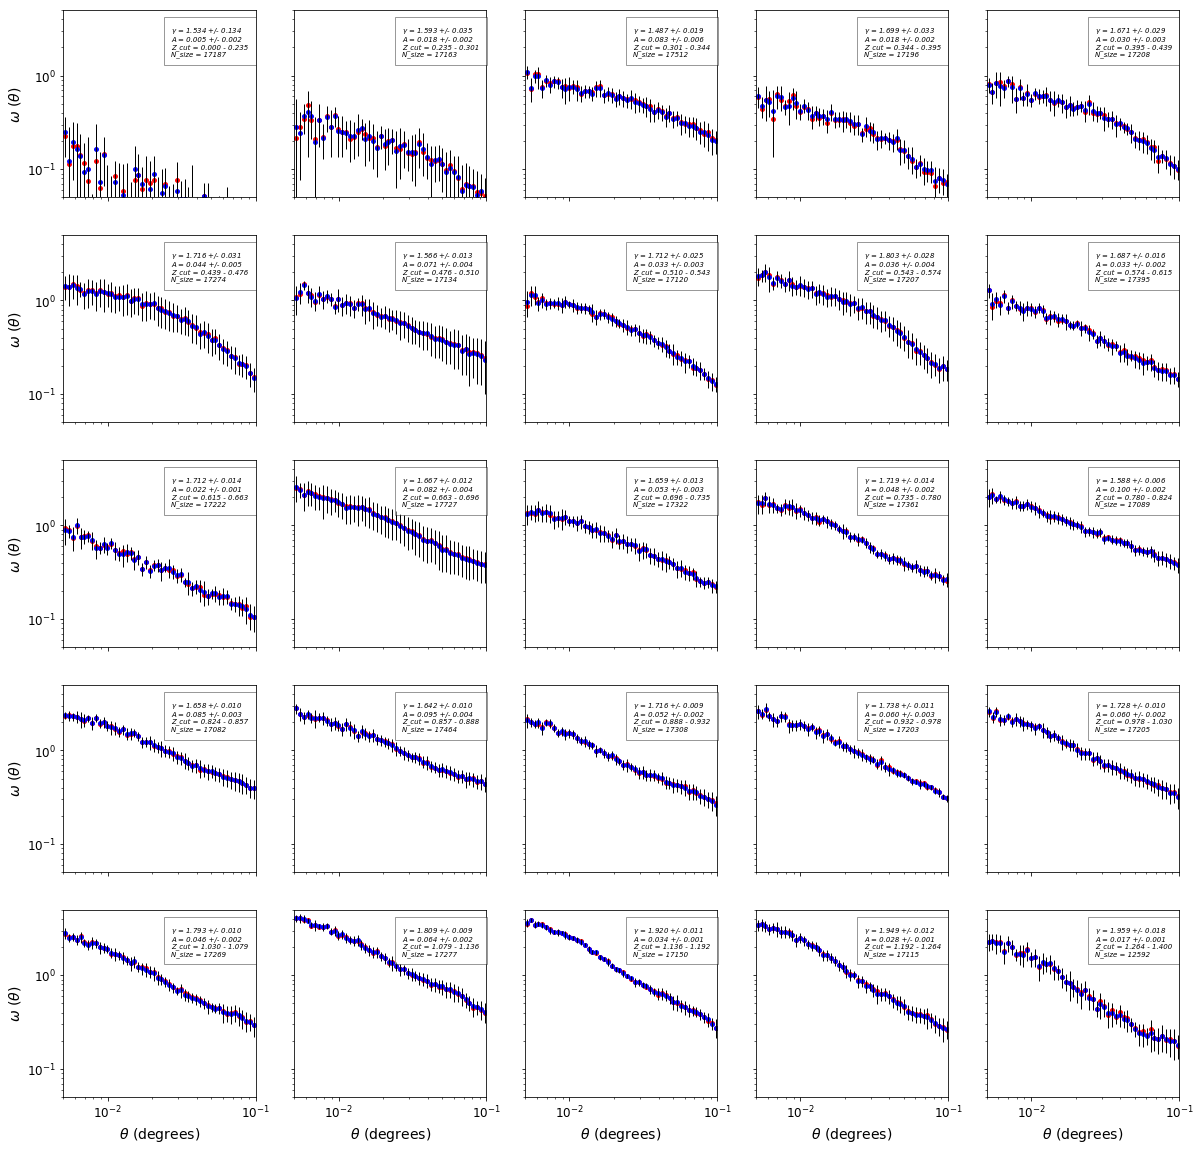

In [69]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (20,20))
rep = []
for i in range(5):
    rep.append (5*i)
    for j in range(5):
        #ax[i, j].plot(r_value[rep[i] + j], yfit_eq[rep[i] + j], color = 'green', lw = 2)
        ax[i,j].scatter(r_value[rep[i] + j], xi_value[rep[i] + j], color='red', s = 15)
        ax[i,j].scatter(r_value[rep[i] + j], def_xi[rep[i] + j], color='blue', s = 15)
        #ax[i,j].scatter(r_value[rep[i] + j], -xi_value[rep[i] + j], color='blue', s = 15)
        ax[i,j].errorbar(r_value[rep[i] + j], def_xi[rep[i] + j], yerr = cov_final[rep[i] + j], color='black', lw=1, ls='')
        #ax[i,j].errorbar(r_value[rep[i] + j], -xi_value[rep[i] + j], yerr= xi_err[rep[i] + j], color='black', lw=1, ls='')                 
        ax[4,j].set_xlabel(r'$\theta$ (degrees)', fontsize= 14)
        ax[i,0].set_ylabel(r'$\omega$ ($\theta$)', fontsize = 14)
        #ax[i,j].set_xscale('linear')
        #ax[i,j].set_yscale('linear')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log', nonposy='clip')
        ax[i,j].tick_params (axis = 'both', labelsize = 12)
        ax[i,j].set_xlim(0.005, 0.1)
        ax[i,j].set_ylim(0.05, 5)
        ax[i,j].text (0.027,1.65, r'$\gamma$ = %.3f' % (g_value[rep[i] + j]) + ' +/- %.3f' %(g_err[rep[i] + j])
          + '\n' + r'A = %.3f' % (A_value[rep[i] + j]) + ' +/- %.3f' %(A_err[rep[i] + j])
          + '\n' + r'Z_cut = %.3f' % (z_min[rep[i] + j]) + ' - %.3f' % (z_max[rep[i] + j])
          + '\n' + 'N_size = ' + (N_size[rep[i] + j]),
          #+ '\n' + 'X/ndof = %.3f' %(chisqr[rep[i] + j]) 
          style='italic', fontsize = 7, bbox={'facecolor':'white', 'alpha':0.4, 'pad':7})
fig.savefig('picss.png')

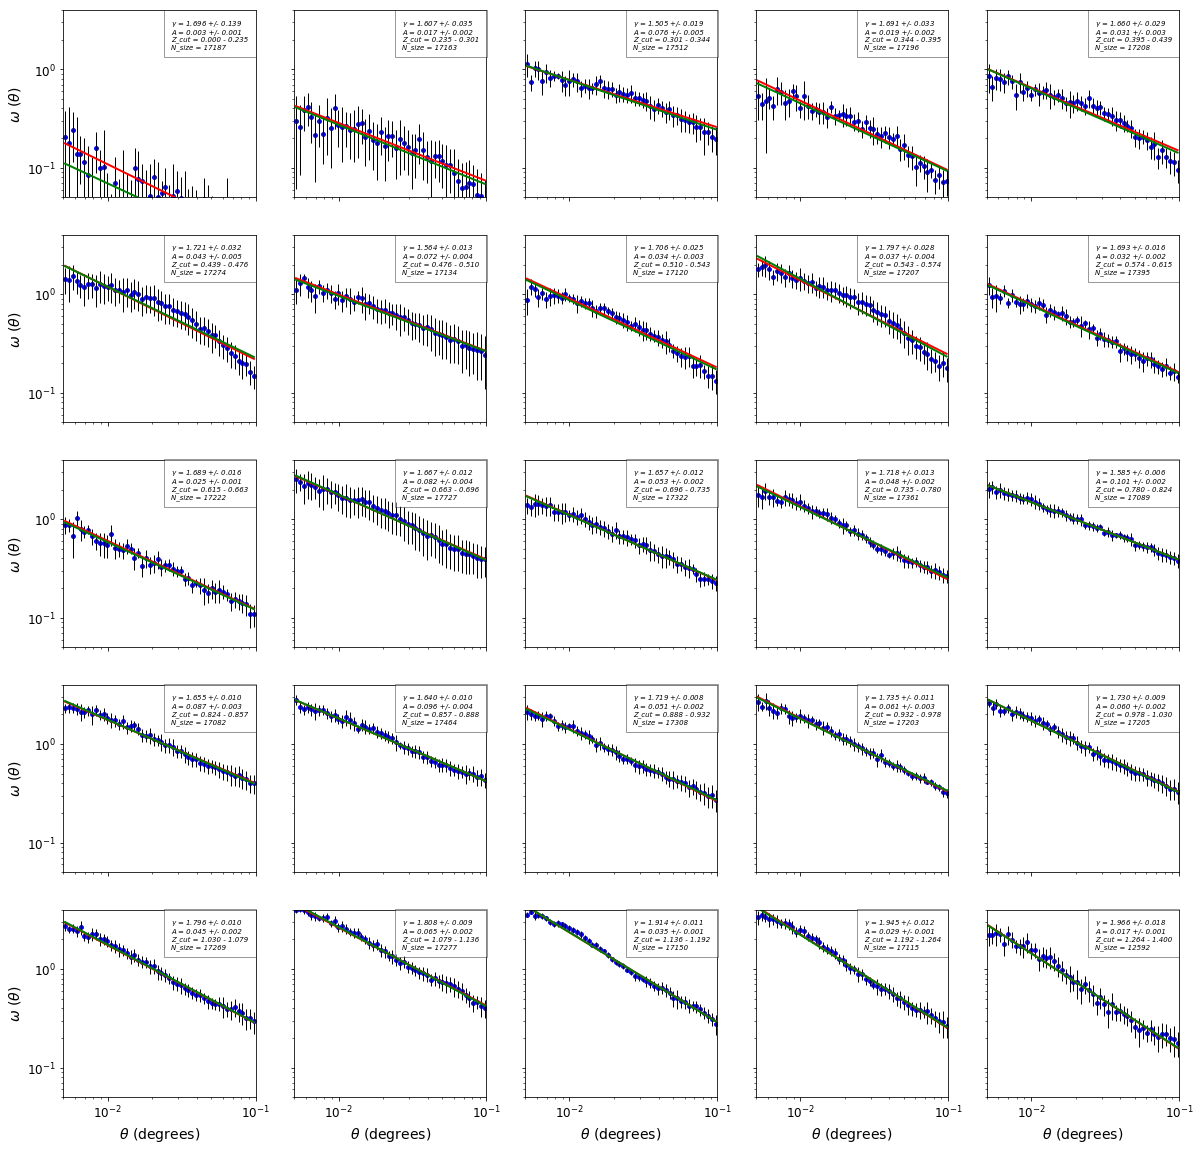

In [34]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (20,20))
rep = []
for i in range(5):
    rep.append (5*i)
    for j in range(5):
        ax[i, j].plot(r_value[rep[i] + j], fin_fit[rep[i] + j], color = 'red', lw = 2)
        ax[i, j].plot(r_value[rep[i] + j], yfit_eq[rep[i] + j], color = 'green', lw = 2)
        ax[i,j].scatter(r_value[rep[i] + j], xi_value[rep[i] + j], color='blue', s = 15)
        #ax[i,j].scatter(r_value[rep[i] + j], def_xi[rep[i] + j], color='blue', s = 15)
        #ax[i,j].scatter(r_value[rep[i] + j], -xi_value[rep[i] + j], color='blue', s = 15)
        #ax[i,j].errorbar(r_value[rep[i] + j], def_xi[rep[i] + j], yerr = (log_error[rep[i] + j]), color='black', lw=1, ls='')
        ax[i,j].errorbar(r_value[rep[i] + j], xi_value[rep[i] + j], yerr = (cov_final[rep[i] + j]), color='black', lw=1, ls='')
        #ax[i,j].errorbar(r_value[rep[i] + j], -xi_value[rep[i] + j], yerr= xi_err[rep[i] + j], color='black', lw=1, ls='')                 
        ax[4,j].set_xlabel(r'$\theta$ (degrees)', fontsize= 14)
        ax[i,0].set_ylabel(r'$\omega$ ($\theta$)', fontsize = 14)
        #ax[i,j].set_xscale('linear')
        #ax[i,j].set_yscale('linear')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log', nonposy='clip')
        ax[i,j].tick_params (axis = 'both', labelsize = 12)
        ax[i,j].set_xlim(0.005, 0.1)
        ax[i,j].set_ylim(0.05, 4)
        ax[i,j].text (0.027,1.65, r'$\gamma$ = %.3f' % (g_value[rep[i] + j]) + ' +/- %.3f' %(g_err[rep[i] + j])
          + '\n' + r'A = %.3f' % (A_value[rep[i] + j]) + ' +/- %.3f' %(A_err[rep[i] + j])
          + '\n' + r'Z_cut = %.3f' % (z_min[rep[i] + j]) + ' - %.3f' % (z_max[rep[i] + j])
          + '\n' + 'N_size = ' + (N_size[rep[i] + j]),
          #+ '\n' + 'X/ndof = %.3f' %(chisqr[rep[i] + j]) 
          style='italic', fontsize = 7, bbox={'facecolor':'white', 'alpha':0.4, 'pad':7})
fig.savefig('picss.png')

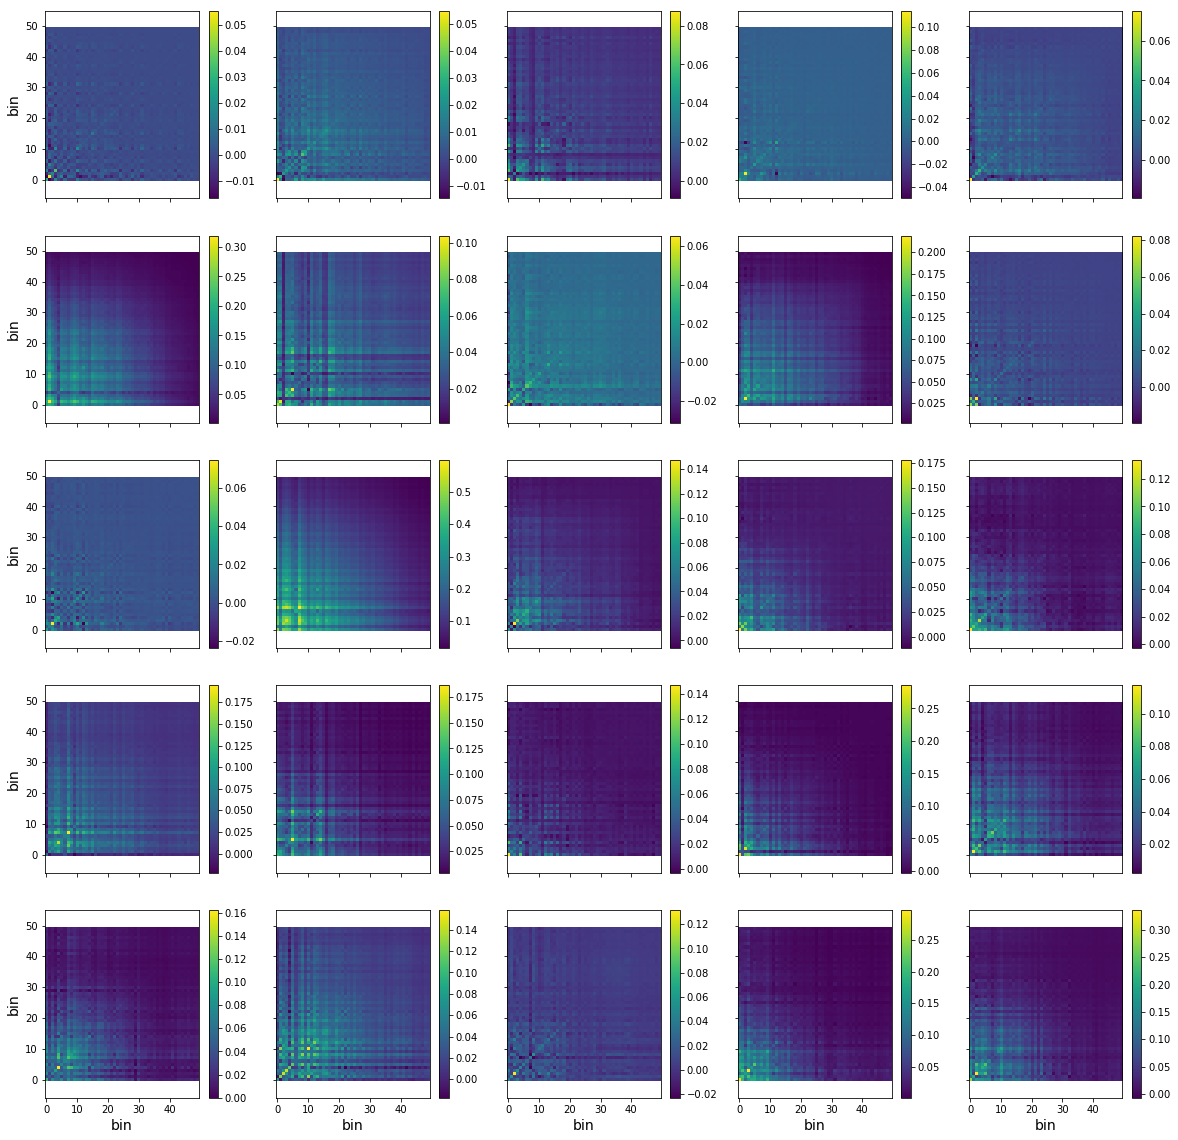

In [24]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (20,20))
rep = []
for i in range(5):
    rep.append (5*i)
    for j in range(5):      
        cax = ax[i, j].imshow(covi_def[rep[i] + j], aspect = 'equal',interpolation = None, origin = 'lower')
        #ax[i, j].colorbar()
        ax[4,j].set_xlabel('bin', fontsize= 14)
        ax[i,0].set_ylabel('bin', fontsize = 14)
        fig.colorbar(cax , ax=ax[i, j])
fig.savefig('picss.png')

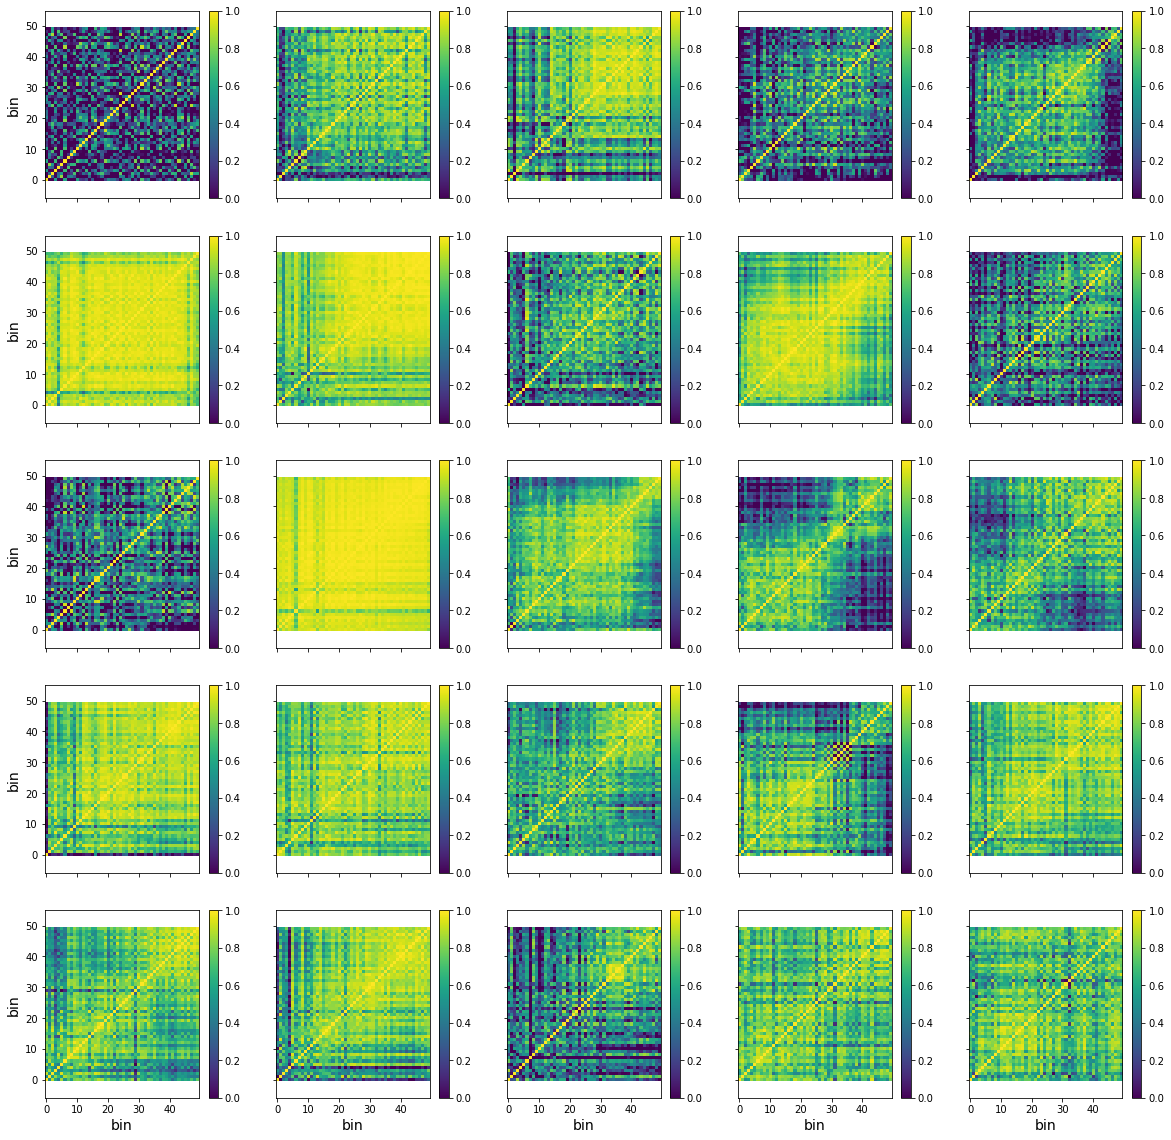

In [43]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize = (20,20))
rep = []
for i in range(5):
    rep.append (5*i)
    for j in range(5):      
        cax = ax[i, j].imshow(corr_def[rep[i] + j], aspect = 'equal',interpolation = None,vmin = 0, vmax = 1, origin = 'lower')
        fig.colorbar(cax , ax=ax[i, j])
        ax[4,j].set_xlabel('bin', fontsize= 14)
        ax[i,0].set_ylabel('bin', fontsize = 14)
fig.savefig('picss.png')

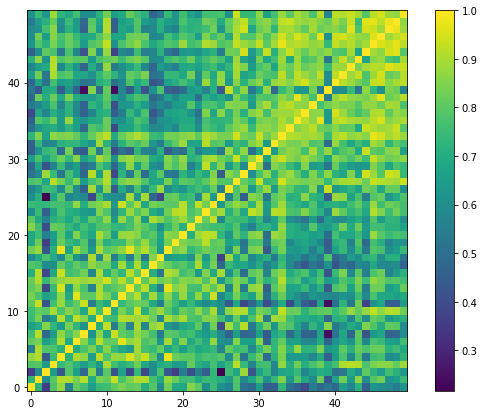

In [75]:
plt.figure(figsize = (10,7))
plt.imshow(corr, aspect = 'equal',interpolation = None, origin = 'lower')
plt.colorbar()
plt.show()

In [28]:
sim = []
for d in range (0,25):
    sim.append(d)

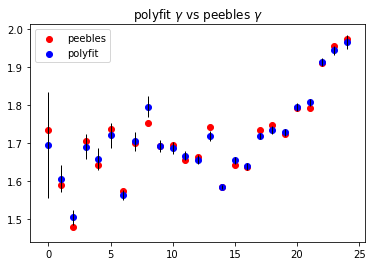

In [29]:
pebg = plt.scatter (sim, fin_gamma, color = 'red')
polyg = plt.scatter (sim, g_value, color = 'blue')
plt.errorbar (sim, g_value, yerr = g_err,color='black', lw=1, ls='')
plt.title ('polyfit $\gamma$ vs peebles $\gamma$')
plt.legend((pebg, polyg), ('peebles', 'polyfit'))
plt.show()

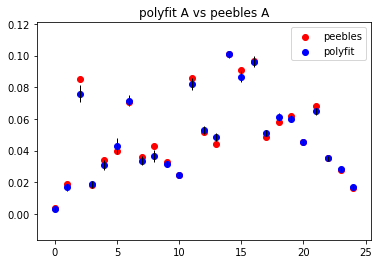

In [31]:
pebA = plt.scatter (sim, fin_A, color = 'red')
polyA = plt.scatter (sim, A_value, color = 'blue')
plt.errorbar (sim, A_value, yerr = A_err,color='black', lw=1, ls='')
plt.title ('polyfit A vs peebles A')
plt.legend((pebA, polyA), ('peebles', 'polyfit'))
plt.show()

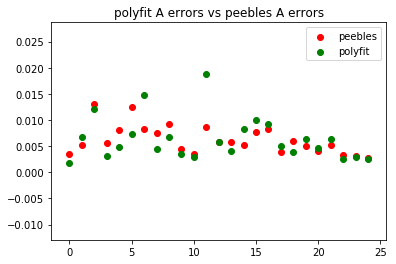

In [32]:
#plt.scatter (sim, A_err, color = 'blue')
pebA = plt.scatter (sim, A_newerr, color = 'red')
polyA = plt.scatter (sim, fin_Aerr , color = 'green')
plt.title ('polyfit A errors vs peebles A errors')
plt.legend((pebA, polyA), ('peebles', 'polyfit'))
plt.show()

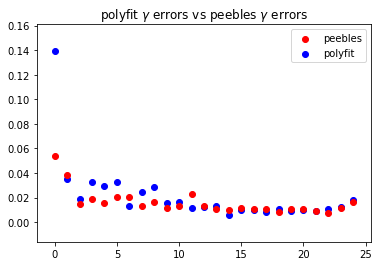

In [33]:
polyg = plt.scatter (sim, g_err, color = 'blue')
pebg = plt.scatter (sim, fin_gerr, color = 'red')
plt.title ('polyfit $\gamma$ errors vs peebles $\gamma$ errors')
plt.legend((pebg, polyg), ('peebles', 'polyfit'))
plt.show()

In [127]:
#cosmology.set_current(WMAP5)
distance = []
for dist in xrange (1 ,14, 3):
    d1 = cosmo.comoving_distance([dist/10.0])
    distance.append((d1.value))
    print ((distance))

[array([ 417.97770163])]
[array([ 417.97770163]), array([ 1557.32091112])]
[array([ 417.97770163]), array([ 1557.32091112]), array([ 2525.28323438])]
[array([ 417.97770163]), array([ 1557.32091112]), array([ 2525.28323438]), array([ 3340.31019639])]
[array([ 417.97770163]), array([ 1557.32091112]), array([ 2525.28323438]), array([ 3340.31019639]), array([ 4028.35292125])]


In [129]:
newdist = []
for len in range (0,5):
    rval = []
    for r in range (0,50):
        d = distance[len] * r_value[0][r]
        rval.append(d)
    newdist.append(rval)

In [ ]:
plt. plot (r_value[0], newdist[0])
plt. plot (r_value[0], newdist[1])
plt. plot (r_value[0], newdist[2])
plt. plot (r_value[0], newdist[3])
plt. plot (r_value[0], newdist[4])
plt.show()

In [128]:
distance [0]

array([ 417.97770163])